# Victorian Authorship Attribution - Phase 1
TI-IDF +
Tidak menggunakan data prepocessing

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
#with open("data/Gungor_2018_VictorianAuthorAttribution_data.csv", "r", encoding="utf-8", errors="ignore") as f:
#    text = f.read()
#df = pd.read_csv(text)

In [3]:
import os

df_all = "data"
items = os.listdir(df_all)
for name in items:
    print(name)

Data Description.pdf
Gungor_2018_VictorianAuthorAttribution_data-train.csv
Gungor_2018_VictorianAuthorAttribution_data.csv
Gungor_2018_VictorianAuthorAttribution_readme.txt


In [4]:
df_test = pd.read_csv("data/Gungor_2018_VictorianAuthorAttribution_data.csv", encoding="latin1")
df_test.head()

,text
0,nt it seems te me how much money is he worth a...
1,to talk about why you heard of such a case as ...
2,my foot on the ground and said i believe you d...
3,hour or wait for miss oh wait for by all means...
4,will not listen to such words now go and remem...


In [5]:
df_train = pd.read_csv("data/Gungor_2018_VictorianAuthorAttribution_data-train.csv", encoding="latin1")
df_train.head()

,text,author
0,ou have time to listen i will give you the ent...,1
1,wish for solitude he was twenty years of age a...,1
2,and the skirt blew in perfect freedom about th...,1
3,of san and the rows of shops opposite impresse...,1
4,an hour s walk was as tiresome as three in a s...,1


In [6]:
print(df_test.shape)
print(df_train.shape)

(38809, 1)
(53678, 2)


In [7]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53678 entries, 0 to 53677
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    53678 non-null  object
 1   author  53678 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 838.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38809 entries, 0 to 38808
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    38809 non-null  object
dtypes: object(1)
memory usage: 303.3+ KB


## EDA

In [8]:
print(f"Cek df_train Missing Values:", df_train.isna().sum())
print(f"Cek df_train Data Duplicate:", df_train.duplicated().sum())

print(f"Cek df_test Missing Values:", df_test["text"].isna().sum())
print(f"Cek df_test Data Duplicate:", df_test["text"].duplicated().sum())

Cek df_train Missing Values: text      0
author    0
dtype: int64
Cek df_train Data Duplicate: 0
Cek df_test Missing Values: 0
Cek df_test Data Duplicate: 76


Keterangan pada dataset: **No missing values**. Duplicate data pada df_test dihiraukan saja.

In [9]:
# Author distribution
print("\nNumber of unique authors:", df_train['author'].nunique())
print("\nSamples per author:")
author_counts = df_train['author'].value_counts()
print(author_counts.head(10))


Number of unique authors: 45

Samples per author:
author
8     6914
26    4441
14    2696
37    2387
45    2312
21    2307
39    2266
48    1825
33    1742
19    1543
Name: count, dtype: int64


In [10]:
# Text statistics
df_train['text_length'] = df_train['text'].str.len()
df_train['word_count'] = df_train['text'].str.split().str.len()

print(df_train[['text_length', 'word_count']].describe())

        text_length  word_count
count  53678.000000     53678.0
mean    4942.966914      1000.0
std      249.797252         0.0
min     2286.000000      1000.0
25%     4810.000000      1000.0
50%     4956.000000      1000.0
75%     5102.000000      1000.0
max     5760.000000      1000.0


## Spliting Data

In [11]:
df_sample = df_train.sample(n=15000)

X = df_sample["text"]
y = df_sample["author"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_test)} samples")
print(f"Number of authors: {y_train.nunique()}")

Training set: 12000 samples
Validation set: 3000 samples
Number of authors: 45


In [12]:
# Feature Engineering

tfidf_word = TfidfVectorizer(
    analyzer='word',
    max_features=30000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    strip_accents='unicode',
)

X_train_word = tfidf_word.fit_transform(X_train)
X_test_word = tfidf_word.fit_transform(X_test)

print(f"TI-IDF shape: {X_train_word.shape}")
print(f"Vocabulary size: {len(tfidf_word.vocabulary_)}")

TI-IDF shape: (12000, 30000)
Vocabulary size: 30000


In [13]:
# Character-level TF-IDF (better for stylometry)
tfidf_char = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    max_features=3000,
    min_df=2,
    max_df=0.95
)
X_train_char = tfidf_char.fit_transform(X_train)
X_test_char = tfidf_char.transform(X_test)
print(f"Char n-gram shape: {X_train_char.shape}")

Char n-gram shape: (12000, 3000)


**Feature Engineering (Stylometric Feature)**

implementasi feature engineering (Stylometric Feature)

In [14]:
import re

print("PHASE 2: STYLOMETRIC FEATURE ENGINEERING")
print("="*80)

def extract_stylometric_features(text):
    """
    Extract various stylometric features that capture writing style
    Based on research: character-level and lexical patterns are strong indicators
    """
    features = {}

    # Basic statistics
    features['text_length'] = len(text)
    words = text.split()
    features['word_count'] = len(words)
    features['avg_word_length'] = np.mean([len(w) for w in words]) if words else 0
    features['vocab_richness'] = len(set(words)) / len(words) if words else 0

    # Character frequencies
    features['uppercase_ratio'] = sum(1 for c in text if c.isupper()) / len(text) if text else 0
    features['digit_ratio'] = sum(1 for c in text if c.isdigit()) / len(text) if text else 0
    features['whitespace_ratio'] = sum(1 for c in text if c.isspace()) / len(text) if text else 0

    # Punctuation patterns (Victorian authors have distinctive punctuation styles)
    features['comma_freq'] = text.count(',') / len(text) if text else 0
    features['semicolon_freq'] = text.count(';') / len(text) if text else 0
    features['colon_freq'] = text.count(':') / len(text) if text else 0
    features['exclamation_freq'] = text.count('!') / len(text) if text else 0
    features['question_freq'] = text.count('?') / len(text) if text else 0
    features['period_freq'] = text.count('.') / len(text) if text else 0
    features['dash_freq'] = text.count('--') / len(text) if text else 0
    features['quote_freq'] = text.count('"') / len(text) if text else 0

    # Sentence statistics
    sentences = [s.strip() for s in re.split(r'[.!?]+', text) if s.strip()]
    features['sentence_count'] = len(sentences)
    features['avg_sentence_length'] = np.mean([len(s.split()) for s in sentences]) if sentences else 0

    # Function words (common in stylometry)
    function_words = ['the', 'of', 'and', 'to', 'a', 'in', 'that', 'is', 'was', 'he', 'for', 'it', 'with', 'as', 'his', 'on', 'be', 'at', 'by', 'i', 'this', 'had', 'not', 'are', 'but', 'from', 'or', 'have', 'an', 'they', 'which', 'one', 'you', 'were', 'her', 'all', 'she', 'there', 'would', 'their']
    text_lower = text.lower()
    for fw in function_words[:20]:  # Top 20 function words
        features[f'fw_{fw}'] = text_lower.split().count(fw) / len(words) if words else 0

    return features

PHASE 2: STYLOMETRIC FEATURE ENGINEERING


In [15]:
print(f"\nExtracting stylometric features...")
stylo_train = pd.DataFrame([extract_stylometric_features(text) for text in X_train])
stylo_test = pd.DataFrame([extract_stylometric_features(text) for text in X_test])


Extracting stylometric features...


In [16]:
# Normalize stylometric features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
stylo_train_scaled = scaler.fit_transform(stylo_train)
stylo_test_scaled = scaler.fit_transform(stylo_test)

print(f"Stylometric features shape: {stylo_train_scaled.shape}")
print(f"Features: {stylo_train.columns.tolist()[:10]}...")

Stylometric features shape: (12000, 37)
Features: ['text_length', 'word_count', 'avg_word_length', 'vocab_richness', 'uppercase_ratio', 'digit_ratio', 'whitespace_ratio', 'comma_freq', 'semicolon_freq', 'colon_freq']...


In [17]:
# Features combination
from scipy.sparse import hstack

X_train_combined = hstack([X_train_char, stylo_train_scaled])
X_test_combined = hstack([X_test_char, stylo_test_scaled])
print(f"Combined features shape: {X_train_combined.shape}")

Combined features shape: (12000, 3037)


## Model Machine Leaning

In [18]:
models = {
    'Logistic Regression': LogisticRegression(),  # default params
    'Linear SVM': LinearSVC(),
}
results = []

for name, model in models.items():
    print(f"\nTraning {name}...")
    model.fit(X_train_combined, y_train)

    y_pred = model.predict(X_test_combined)
    acc = accuracy_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': acc,
    })

    print(f"{name} Accuracy: {acc:.4f}")


Traning Logistic Regression...
Logistic Regression Accuracy: 0.7397

Traning Linear SVM...
Linear SVM Accuracy: 0.9000


In [19]:
# Result
results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
print("\n" + "-"*20)
print("Baseline Model Summary")
print("="*20)
print(results_df.to_string(index=False))


--------------------
Baseline Model Summary
              Model  Accuracy
         Linear SVM  0.900000
Logistic Regression  0.739667



✓ Visualization saved: baseline_comparison.png


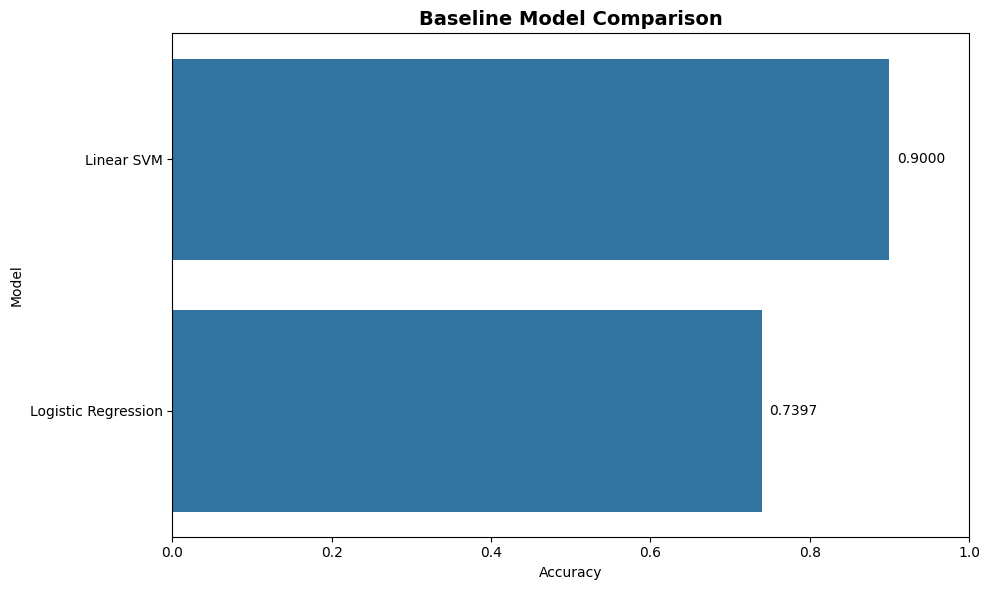

In [20]:
# Visualize results
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Accuracy', y='Model')
plt.title('Baseline Model Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Accuracy')
plt.xlim(0, 1)
for i, v in enumerate(results_df['Accuracy']):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center')
plt.tight_layout()
plt.savefig('baseline_comparison.png', dpi=150, bbox_inches='tight')
print("\n✓ Visualization saved: baseline_comparison.png")

Akurasi tertinggi ada pada Linear SVM dengan 77%

Baseline Model (TF-IDF + SVM)

Kita membutuhkan hyperparameter tuning untuk memperbaiki akurasi.

**Hyperparameter Tuning**

In [21]:
# Hyperparameter tuning..
print("\n1. Tuning SVM ...")
svm_params = {
    'C': [0.1, 1, 10],
    'loss': ['squared_hinge'],
    'max_iter': [3000]
}

svm_grid = GridSearchCV(
    LinearSVC(random_state=42),
    svm_params,
    cv=2,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_train_combined, y_train)
print(f"Best SVM params: {svm_grid.best_params_}")
print(f"Best SVM CV score: {svm_grid.best_score_:.4f}")

svm_best = svm_grid.best_estimator_
svm_test_acc = svm_best.score(X_test_combined, y_test)
print(f"SVM Test accuracy: {svm_test_acc:.4f}")


1. Tuning SVM ...
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best SVM params: {'C': 10, 'loss': 'squared_hinge', 'max_iter': 3000}
Best SVM CV score: 0.8752
SVM Test accuracy: 0.9100


Setelah melihat hasil training, didapat bahwa,

| Model | Akurasi |    
|--------|---------|            
|Logistic regression | 74% |    
| SVM | 91% |                   

Model yang tuned,

| Hyperparameter tuning SVM  | Akurasi |
|--------|---------|
| CV Score (train) | 88% |
| Test Accuracy (test) | 91% | 

- Hasil training phase 1 menghasilkan model SVM menjadi best model dengan akurasi sebesar 91%.
- Hasil hyperparamater tuning dengan GridSearchCV, menghasilkan,
    - Best CV score (train CV): 0.8800
    - Test accuracy: 0.9190
- Perbedaan/gap akurasi antara data train & test sebesar 3%.
- Dengan fitur yang sama di 15.000.

In [22]:
# 3. Refit di full training data pakai best params
svm_best = LinearSVC(
    **{k: v for k, v in svm_grid.best_params_.items()},
    random_state=42
)

svm_best.fit(X_train_combined, y_train)

svm_test_acc = svm_best.score(X_test_combined, y_test)
print(f"SVM Test accuracy: {svm_test_acc:.4f}")

SVM Test accuracy: 0.9100


In [23]:
# 1. Ambil nama fitur char dari vectorizer
feature_names = tfidf_char.get_feature_names_out()
n_char_features = len(feature_names)

# 2. Ambil coef_ dari SVM dan potong hanya bagian fitur char
coef = svm_best.coef_          # shape: (n_classes, n_total_features)
coef_char = coef[:, :n_char_features]   # hanya kolom untuk char n-grams

# 3. Hitung importance (mean absolute value per fitur)
overall_importance_char = np.abs(coef_char).mean(axis=0)

# 4. Buat DataFrame importance khusus char n-grams
importance_df = pd.DataFrame(
    {
        'Feature': feature_names,
        'Importance': overall_importance_char
    }
).sort_values('Importance', ascending=False)

print("Top 20 Most Important Character n-grams:")
print(importance_df.head(20).to_string(index=False))

Top 20 Most Important Character n-grams:
Feature  Importance
   n t     1.115436
     d     1.016102
     â     0.997040
    ie     0.809452
    unt    0.782338
    el     0.772021
     bi    0.765510
    an     0.758618
     vo    0.745976
   d mr    0.744560
    lie    0.727995
   t s     0.727151
     m     0.720849
   stor    0.719786
     t     0.715064
    hap    0.713621
    mil    0.712117
    il     0.709426
     sc    0.708803
    col    0.708601


**Save model**

In [24]:
import joblib

pipeline_dict = {
    "tfidf_char": tfidf_char,
    "scaler": scaler,
    "svm": svm_best,
}

joblib.dump(pipeline_dict, "authorship_pipeline.joblib")

['authorship_pipeline.joblib']